---

<h1 style="text-align: center;font-size: 40px;">Анализ данных продаж видеоигр</h1>

---

### _Подключение необходимых библиотек_

In [2]:
!pip install  missingno 

In [172]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import numpy as np
from scipy import stats
import scipy.stats as sps
pd.set_option('display.max_columns', None)
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import StandardScaler
from statsmodels.sandbox.stats.multicomp import multipletests
import pandas as pd

In [163]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
data = pd.read_csv('vgsales.csv')
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [10]:
data.shape

(16598, 11)

### Предобработка данных

_Удалим данные по играм от 2016 года, поскольку в датасете для них отсутствуют некоторые признаки. Посмотрим также на их количество (чтобы случайно не выкинуть большую часть имеющихся данных):_

In [11]:
drop_row_index = data[data['Year'] > 2015].index
data = data.drop(drop_row_index)
len(drop_row_index)

348

_Видим, что большинство игр в датасете были выпущены ранее 2016 года, что говорит о хорошо подготовленных данных._

### Описание признаков

**Характеристики:**

   * Rank - Рейтинг игры
   
   * Name - Название игры

   * Platform - Платформа, для которой игра предназначена (Персональный компьютер, PlayStation и т.д.)

   * Year - Год релиза игры

   * Genre - Жанр игры

   * Publisher - Компания, выпустившая игру

   * NA_Sales - Продажи в Северной Америке (в миллионах)

   * EU_Sales - Продажи в Европе (в миллионах)

   * JP_Sales - Продажи в Японии (в миллионах)

   * Other_Sales - Продажи в остальных странах (в миллионах)

   * Global_Sales - Общемировые продажи (в миллионах)



In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16250 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16250 non-null  int64  
 1   Name          16250 non-null  object 
 2   Platform      16250 non-null  object 
 3   Year          15979 non-null  float64
 4   Genre         16250 non-null  object 
 5   Publisher     16194 non-null  object 
 6   NA_Sales      16250 non-null  float64
 7   EU_Sales      16250 non-null  float64
 8   JP_Sales      16250 non-null  float64
 9   Other_Sales   16250 non-null  float64
 10  Global_Sales  16250 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Общая информация

In [15]:
data.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16250.000000,15979.000000,16250.000000,16250.000000,16250.000000,16250.000000,16250.000000
mean,8233.153785,2006.197071,0.268924,0.148146,0.078601,0.048614,0.544564
std,4775.382512,5.714810,0.824467,0.509035,0.312196,0.190271,1.569213
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4095.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8213.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12340.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,16600.000000,2015.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [16]:
data.describe(include=['object', 'bool'])

,Name,Platform,Genre,Publisher
count,16250,16250,16250,16194
unique,11296,31,12,566
top,Need for Speed: Most Wanted,DS,Action,Electronic Arts
freq,12,2162,3196,1331


_Уже сейчас можно сделать несколько выводов_:
* _Рассматриваются игры с 1980 до 2015 года_
* _Продажи по миру лежат в диапазоне от 0.01 млн долларов до 82.74 млн долларов_
* _В среднем продажи в Северной Америке составляли примерно столько же, что и по Европе, Японии и всем остальным странам вместе взятым_


# 1. Игр какого жанра было сделано больше всего?

In [18]:
data['Genre'].value_counts()

Action          3196
Sports          2308
Misc            1721
Role-Playing    1446
Shooter         1278
Adventure       1252
Racing          1229
Platform         876
Simulation       857
Fighting         834
Strategy         671
Puzzle           582
Name: Genre, dtype: int64

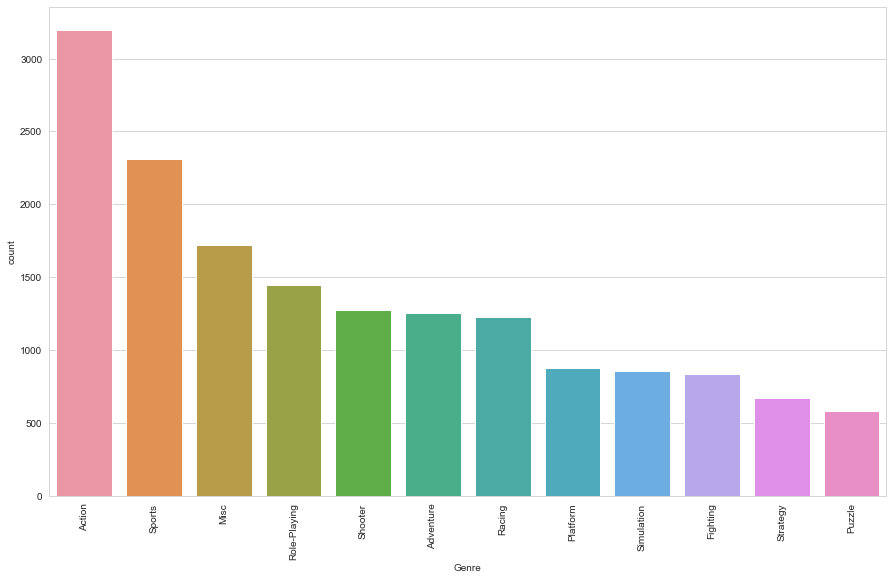

In [23]:
plt.figure(figsize=(15, 9))
sns.countplot(x="Genre", data=data, order = data['Genre'].value_counts().index)
plt.xticks(rotation=90);

_Видно, что подавляющее большинство игр имеют жанр экшн/cпорт (свыше 5500), а стратегий и головоломок минимальное количество (около 1200). Это может быть связано с куда большей популярностью лидирующих жанров и использование одного для выпуска новых выбор (можно привести в качестве примера серию игр FIFA)._

# 2. Какой год стал самым продуктивным в игровой индустрии?

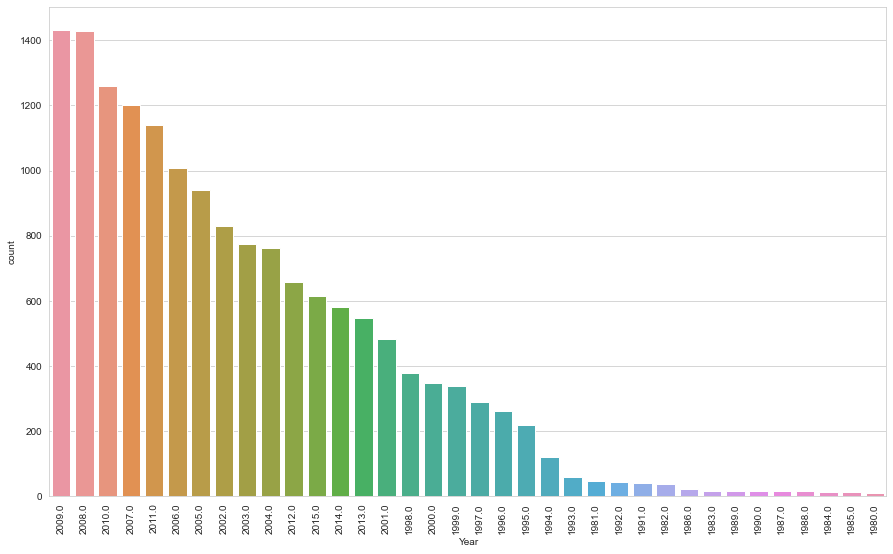

In [72]:
plt.figure(figsize=(15, 9))
sns.countplot(x="Year", data=data, order = data.groupby(by=['Year'])['Name'].count().sort_values(ascending=False).index)
plt.xticks(rotation=90);

_Видно, что в период 2007-2011 годы было выпущено наибольшее количество игр (см. распределение ниже), причём стоит обратить внимание на тенденцию: количество выпущенных игр практически монотонно росло с 1993 года, а затем в 2012-2013 году произошёл резкий "обвал" по количеству выпускаемых игр (практически в 2 раза)._

# 3. Распределение по жанрам игр в 2007-2011 годах

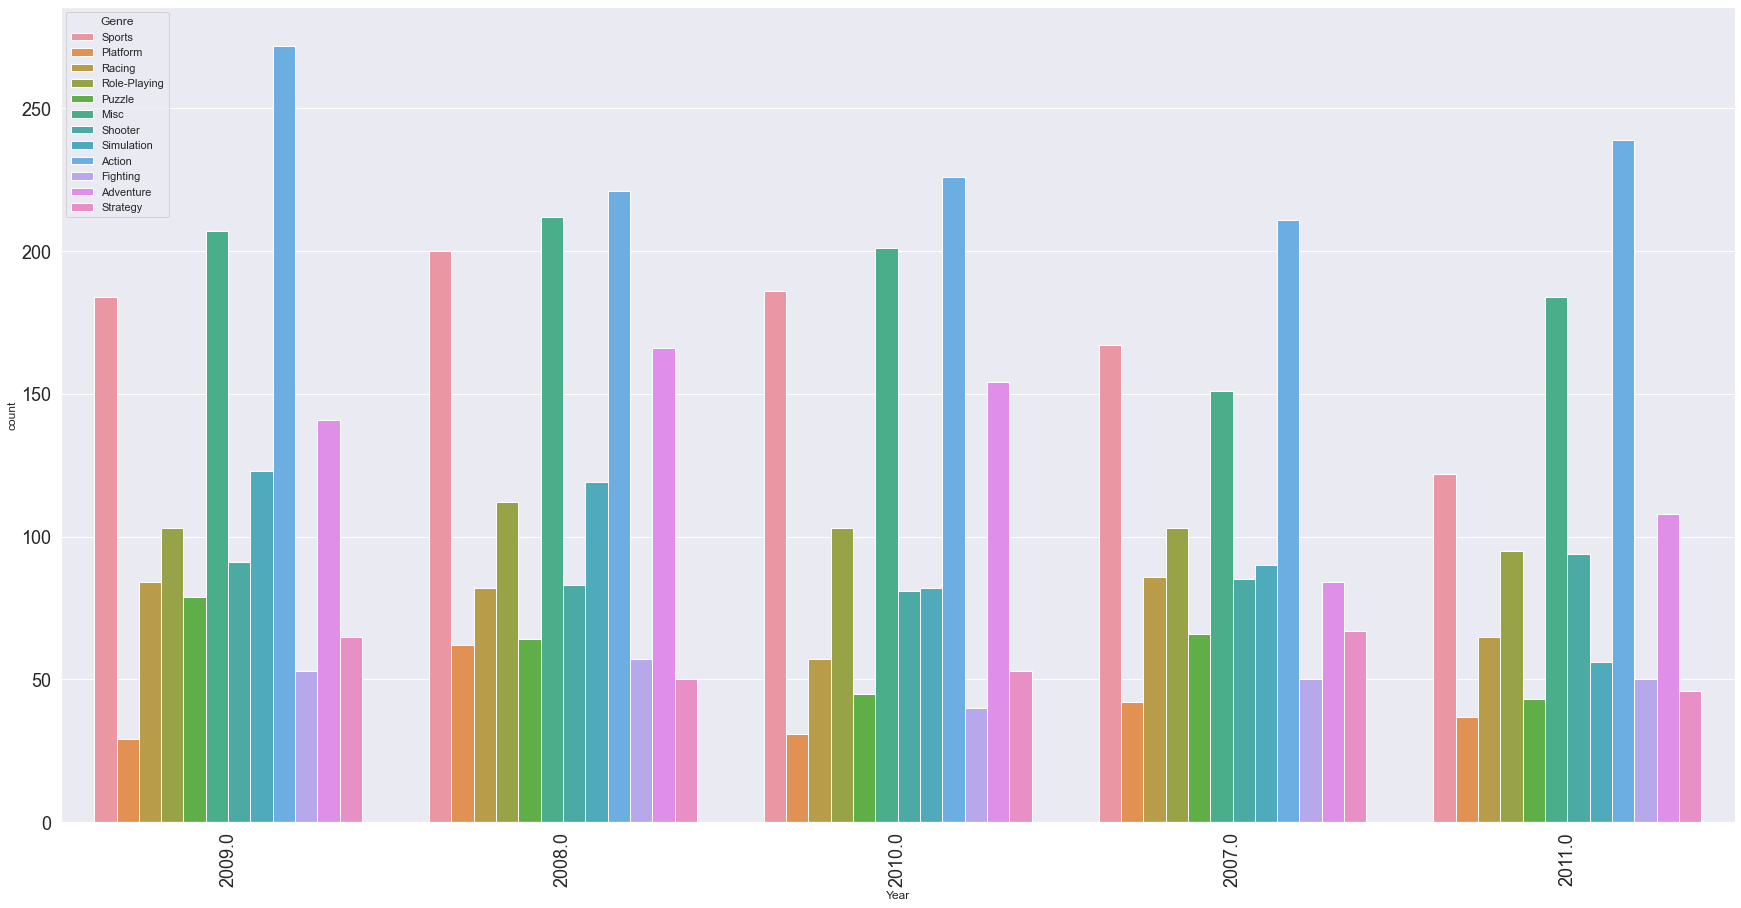

In [131]:
plt.figure(figsize=(30, 15))
sns.countplot(x="Year", data=data, hue='Genre', order=data.Year.value_counts().iloc[:5].index)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18);

In [69]:
data.groupby(by=['Year'])['Name'].count().sort_values(ascending=False).iloc[:5].values

array([1431, 1428, 1259, 1202, 1139], dtype=int64)

_Если взглянуть на пункт выше, то можно заметить, что, несмотря на одинаковое количество игр в 2008-2009 годах, в 2008 было более равномерное по жанрам распределение, чем в 2009 году._

# 4. В каком году были самые высокие продажи по всему миру?

In [70]:
data_year = data.groupby(by=['Year'])['Global_Sales'].sum()
data_year = data_year.reset_index()
# data_year.sort_values(by=['Global_Sales'], ascending=False)

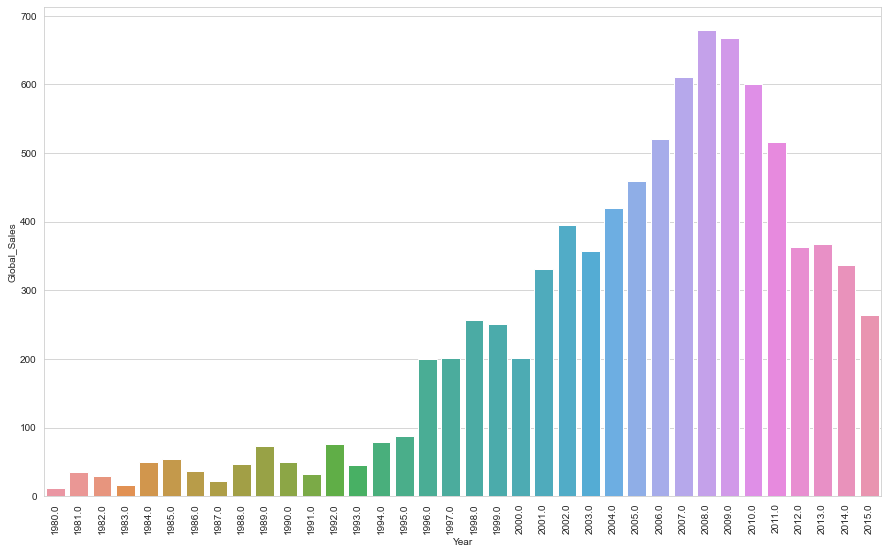

In [73]:
plt.figure(figsize=(15, 9))
sns.barplot(x="Year", y="Global_Sales", data=data_year)
plt.xticks(rotation=90);

_Оказалось, что наибольшие продажи были в 2008 и 2009 году, что сходится с пунктом выше про количество произведённых игр (больше игр - больше продажи). Однако стоит отметить 2006 год, который здесь находится в топ-5 по продажам, а по количеству игр он в топ-5 не вошёл._

# 5. В какие годы было выпущено наибольшее количество игр одного жанра?

In [74]:
year_max_df = data.groupby(['Year', 'Genre']).size().reset_index(name='count')
year_max_idx = year_max_df.groupby(['Year'])['count'].transform(max) == year_max_df['count']
year_max_genre = year_max_df[year_max_idx].reset_index(drop=True)
year_max_genre = year_max_genre.drop_duplicates(subset=["Year", "count"], keep='last').reset_index(drop=True)
# year_max_genre

In [75]:
genre = year_max_genre['Genre'].values
# genre[0]

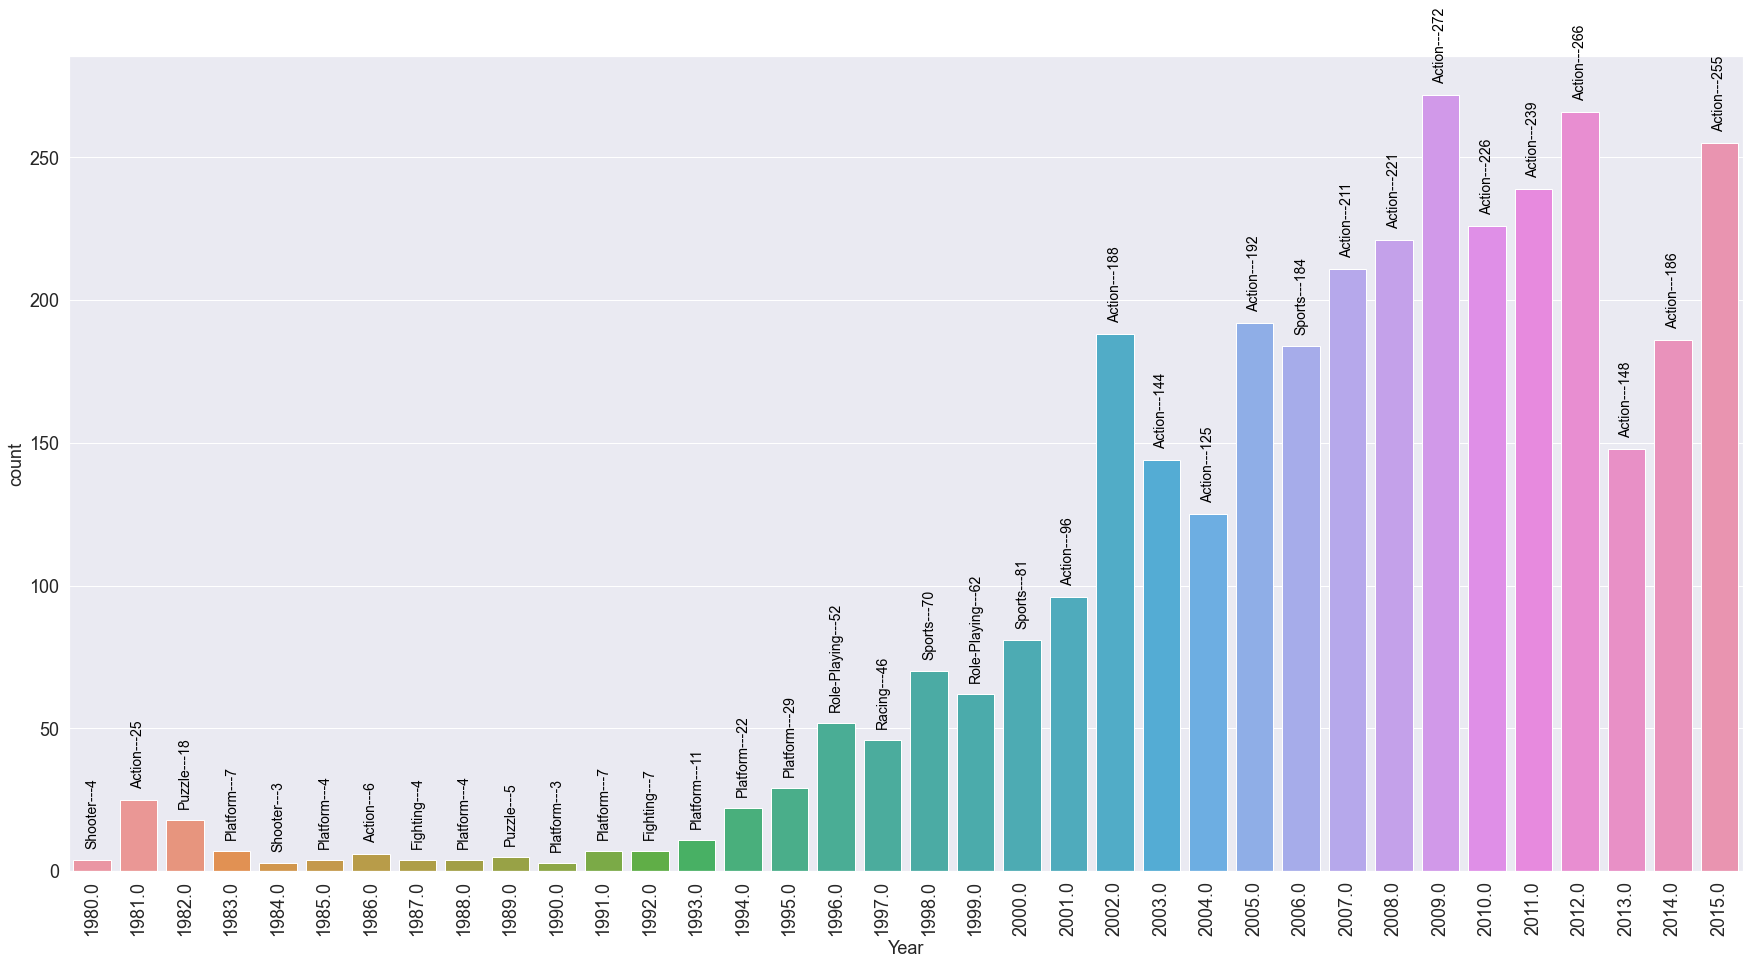

In [130]:
plt.figure(figsize=(30, 15))
g = sns.barplot(x='Year', y='count', data=year_max_genre)
index = 0
for value in year_max_genre['count'].values:
    g.text(index, value + 5, str(genre[index] + '---' +str(value)), color='#000', size=14, rotation= 90, ha="center")
    index += 1

plt.xlabel('Year', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.show()

_Наиболее продуктивными являются 2009 и 2012 г. с 272 и 266 играми в жанре экшн._

# 6. Игра какого жанра была продана больше всего за один год?

In [82]:
year_sale_dx = data.groupby(by=['Year', 'Genre'])['Global_Sales'].sum().reset_index()
year_sale = year_sale_dx.groupby(by=['Year'])['Global_Sales'].transform(max) == year_sale_dx['Global_Sales']
year_sale_max = year_sale_dx[year_sale].reset_index(drop=True)
# year_sale_max

In [83]:
genre = year_sale_max['Genre']

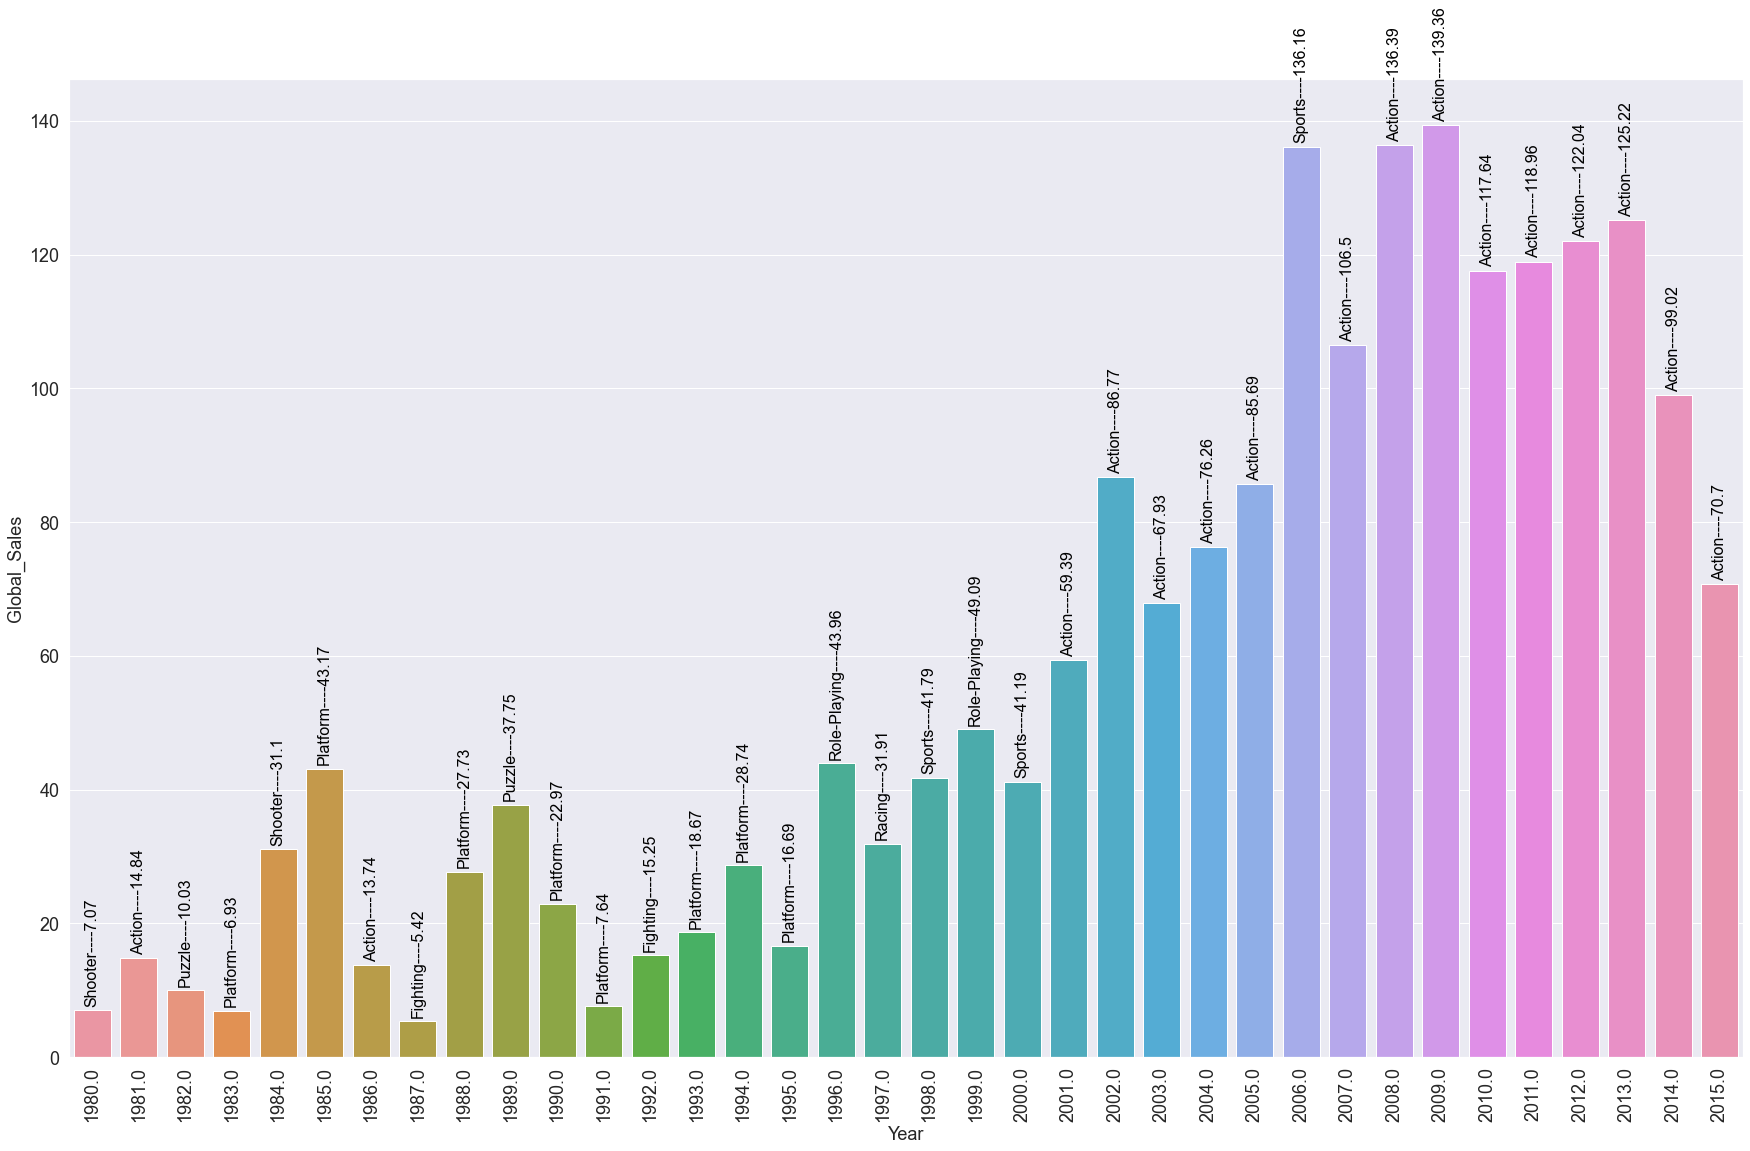

In [129]:
plt.figure(figsize=(30, 18))
g = sns.barplot(x='Year', y='Global_Sales', data=year_sale_max)
index = 0
for value in year_sale_max['Global_Sales']:
    g.text(index, value + 1, str(genre[index] + '----' +str(round(value, 2))), 
           color='#000', size=16, rotation= 90, ha="center")
    index += 1

plt.xlabel('Year', fontsize=18)
plt.ylabel('Global_Sales', fontsize=18)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.show()

_В 2009 году игры жанра экшн принесли 139.36 млн и в 2008 году 136.39 млн._

# 7. Игры какого жанра имеют самые высокие продажи в мире

In [86]:
data_genre = data.groupby(by=['Genre'])['Global_Sales'].sum()
data_genre = data_genre.reset_index()
data_genre = data_genre.sort_values(by=['Global_Sales'], ascending=False)
# data_genre

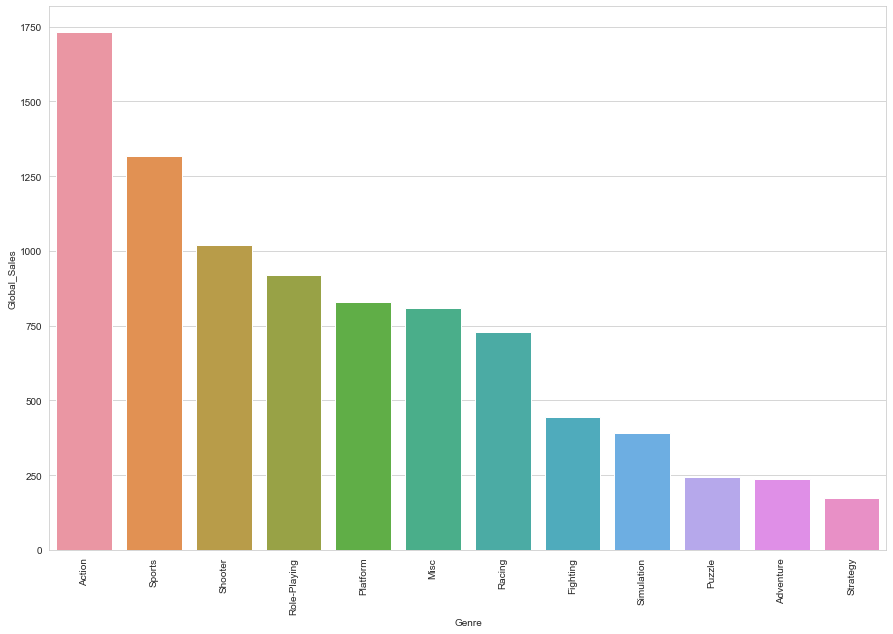

In [88]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Genre", y="Global_Sales", data=data_genre)
plt.xticks(rotation=90);

_Становится понятным, что жанры экшн и спортивный всегда находятся высоко, хотя при этом на 3 месте стоят шутеры, которые по количеству игр они только на 5-ом месте._

# 8. Какие платформы имеют самые высокие  продажи в мире

In [89]:
data_platform = data.groupby(by=['Platform'])['Global_Sales'].sum()
data_platform = data_platform.reset_index()
data_platform = data_platform.sort_values(by=['Global_Sales'], ascending=False)
# data_platform

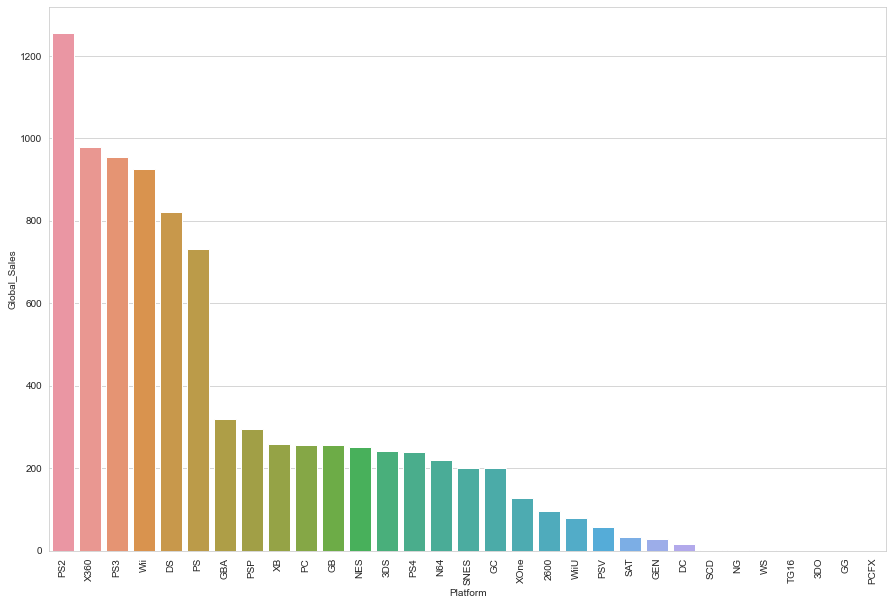

In [91]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Platform", y="Global_Sales", data=data_platform)
plt.xticks(rotation=90);

_Можно сделать вывод, что наиболее прибыльными за рассмтриваемый период оказались PS2, X360 и PS3._

# 9. Какая игра имеет самую высокие продажи в мире?

In [92]:
top_game_sale = data.head(20)
top_game_sale = top_game_sale[['Name', 'Year', 'Genre', 'Global_Sales']]
top_game_sale = top_game_sale.sort_values(by=['Global_Sales'], ascending=False)
# top_game_sale

In [93]:
name = top_game_sale['Name']
year = top_game_sale['Year']
y = np.arange(0, 20)

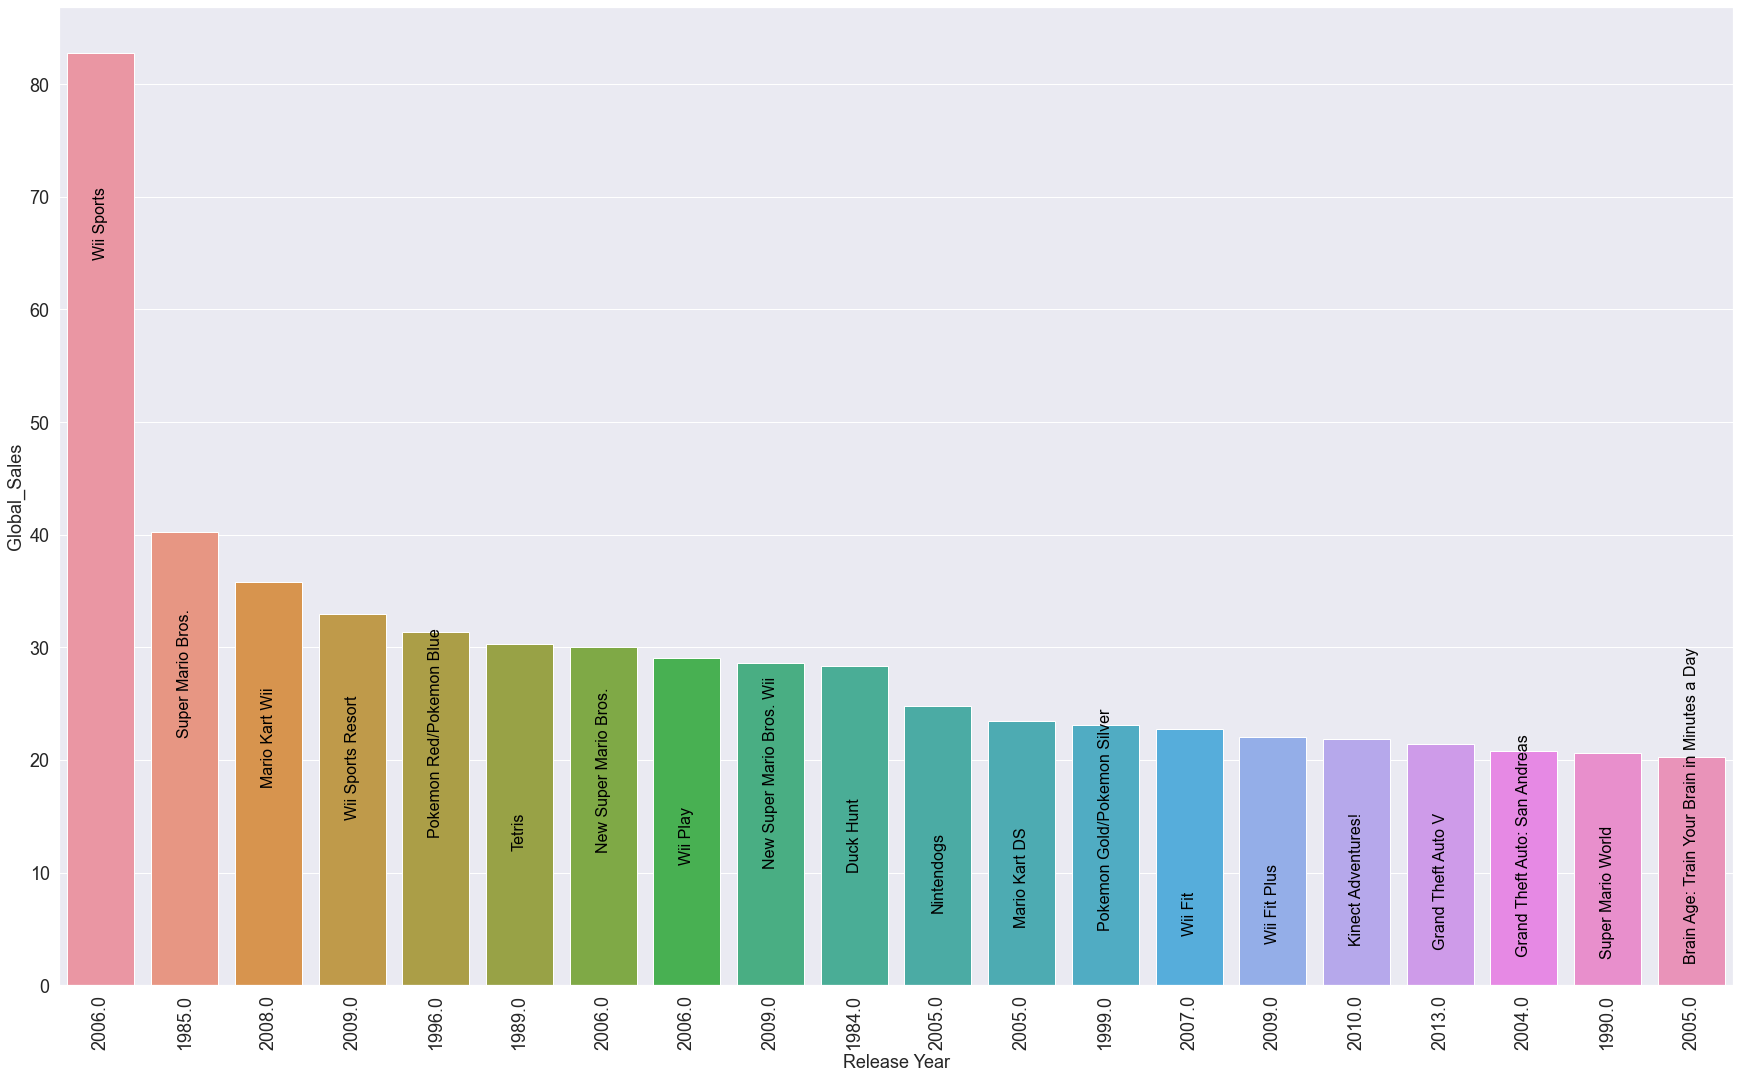

In [127]:
plt.figure(figsize=(30, 18))
g = sns.barplot(x='Name', y='Global_Sales', data=top_game_sale)
index = 0
for value in top_game_sale['Global_Sales']:
    g.text(index, value - 18, name[index], color='#000', size=16, rotation= 90, ha="center")
    index += 1

plt.xticks(y, top_game_sale['Year'], fontsize=18, rotation=90)
plt.xlabel('Release Year', fontsize=18)
plt.ylabel('Global_Sales', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

_Здесь лидер Wii Sports, однако стоит понимать, что сюда не вошли игры по типу "Minecraft", которые до сих пор разрабатываются и приносят большое количество прибыли._

**Перейдём к сравнениям:**

# 10. Сравнение продаж по жанрам

In [95]:
comp_genre = data[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
# comp_genre
comp_map = comp_genre.groupby(by=['Genre']).sum()
# comp_map

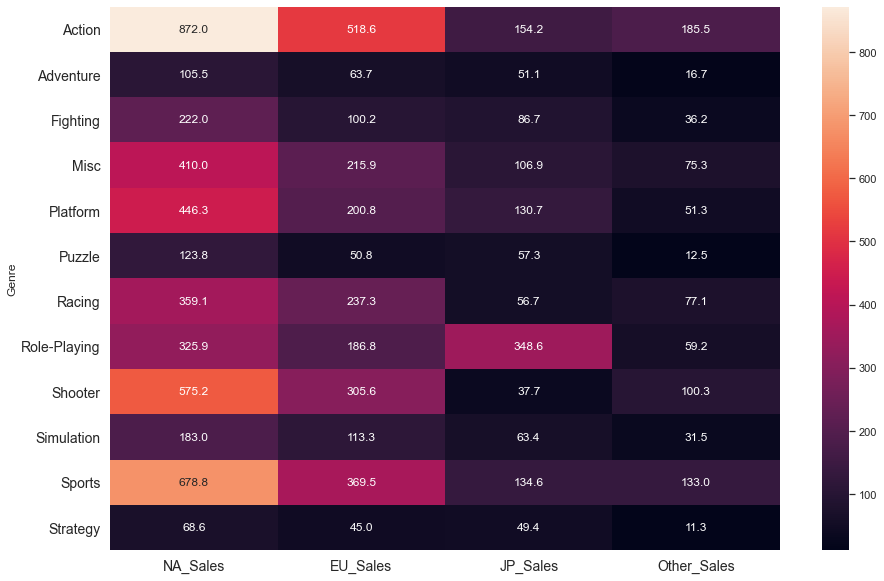

In [96]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.heatmap(comp_map, annot=True, fmt = '.1f')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [97]:
comp_table = comp_map.reset_index()
comp_table = pd.melt(comp_table, id_vars=['Genre'], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], var_name='Sale_Area', value_name='Sale_Price')
comp_table.head()

,Genre,Sale_Area,Sale_Price
0,Action,NA_Sales,871.96
1,Adventure,NA_Sales,105.46
2,Fighting,NA_Sales,221.99
3,Misc,NA_Sales,410.02
4,Platform,NA_Sales,446.26


<AxesSubplot:xlabel='Genre', ylabel='Sale_Price'>

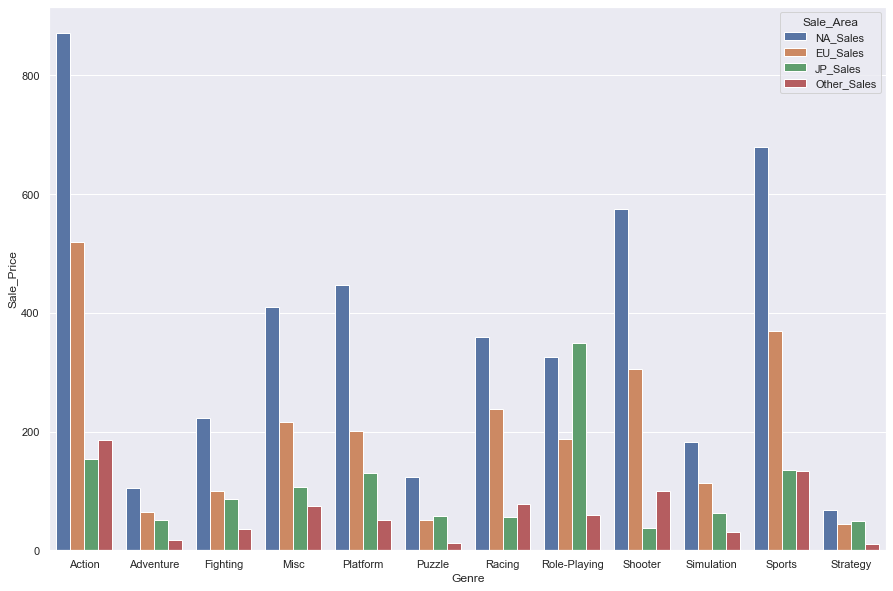

In [98]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Genre', y='Sale_Price', hue='Sale_Area', data=comp_table)

_Здесь интересно следующее: наиболее увлечёнными в играх явно оказываются жители Америки, однако конкретно в жанре ролевых игр их всё равно опережают японцы (что объяснимо в силу их культуры), при этом сами японцы крайне неохотно тратятся на шутеры (разница между ролевыми играми и шутерами составляет более 10 раз). Также стоит отметить, что Европа по всем жанрам похожа на Америку, только в меньшем масштабе (то есть процент продаж от жанра к жанру практически не меняется в отношении Европа/Америка)._

# 11. Сравнение продаж по платформам

In [99]:
comp_platform = data[['Platform', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
comp_platform.head()

,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Wii,41.49,29.02,3.77,8.46
1,NES,29.08,3.58,6.81,0.77
2,Wii,15.85,12.88,3.79,3.31
3,Wii,15.75,11.01,3.28,2.96
4,GB,11.27,8.89,10.22,1.00


In [100]:
comp_platform = comp_platform.groupby(by=['Platform']).sum().reset_index()

In [101]:
# comp_table = comp_map.reset_index()
comp_table = pd.melt(comp_platform, id_vars=['Platform'], value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], var_name='Sale_Area', value_name='Sale_Price')
comp_table.head()

,Platform,Sale_Area,Sale_Price
0,2600,NA_Sales,90.60
1,3DO,NA_Sales,0.00
2,3DS,NA_Sales,78.04
3,DC,NA_Sales,5.43
4,DS,NA_Sales,390.44


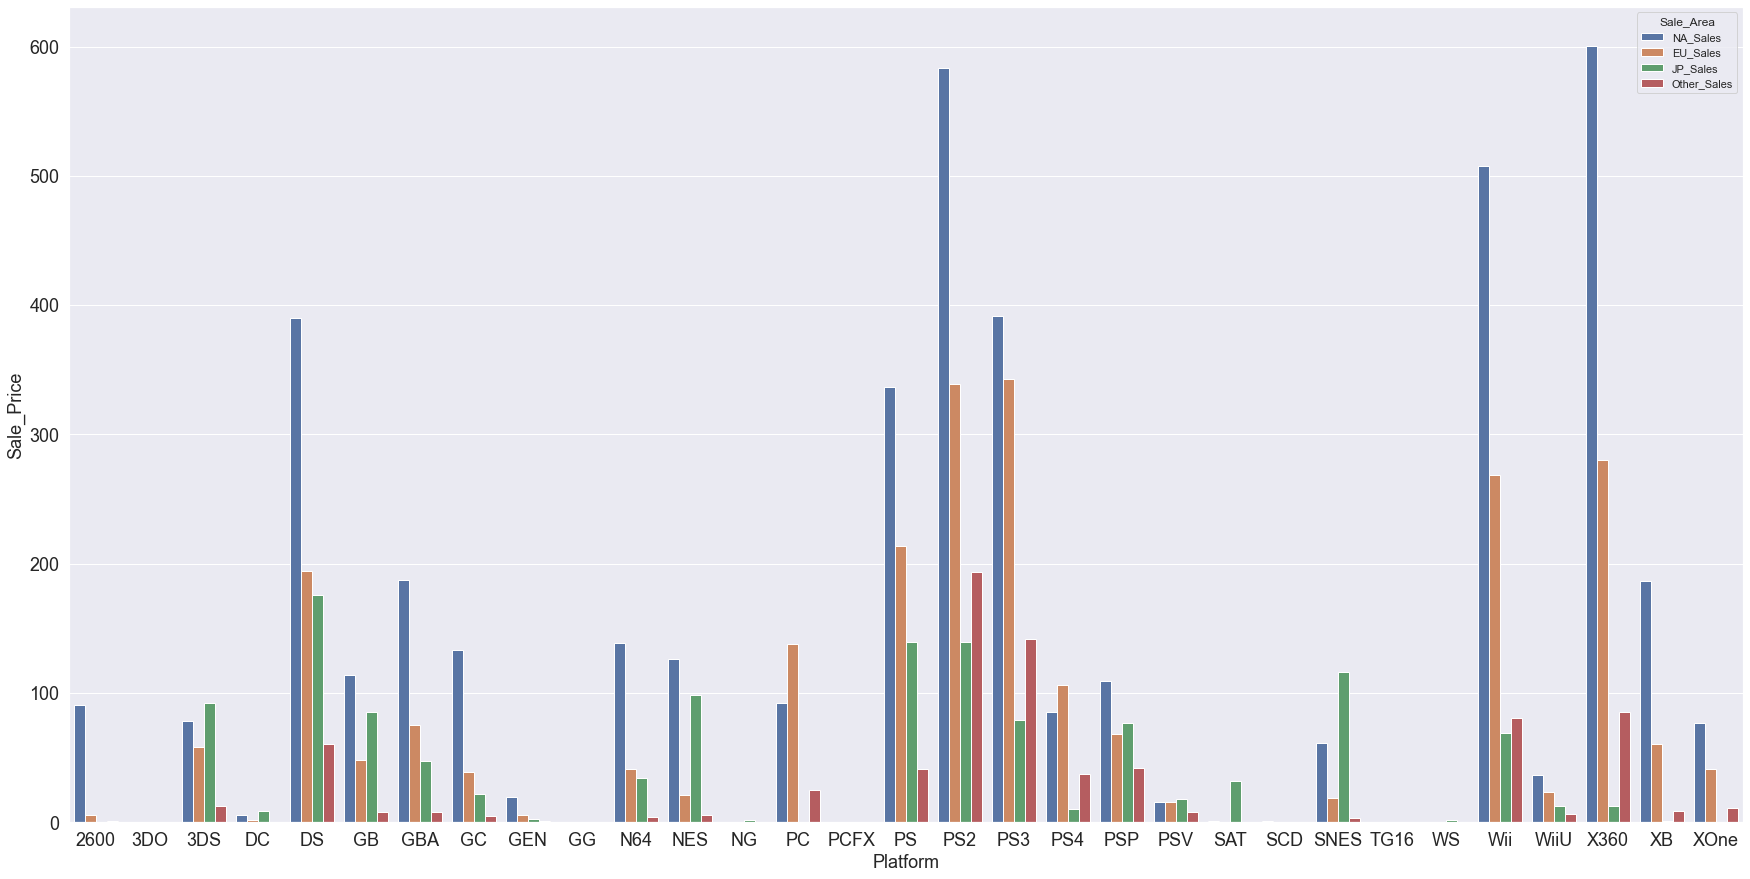

In [125]:
plt.figure(figsize=(30, 15))
sns.barplot(x='Platform', y='Sale_Price', hue='Sale_Area', data=comp_table)
plt.xlabel('Platform', fontsize=18)
plt.ylabel('Sale_Price', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

_Здесь можно сделать сразу несколько выводов. Тенденция доминирования Америки сохраняется, однако:_  
_1) Для персональных компьютеров рынок Европы оказался привлекательнее, при этом для Японии вообще нет на игры на ПК никакого спроса._   
_2) При этом в Японии, что логично, уважают Super Nintendo Entertainment System (SNES), и увлекаются ими примерно так же, как и европейцы ПК._    
_3) Отдельно стоит сказать про тенденцию роста интереса европейцев к серии PlayStation, видно, что при переходе от PS2 до PS4 продажи увеличиваются в Европе и сокращаются в Америке._    
_4) Некоторые консоли (GG, 3DO, SCD и другие) вообще существовали, кажется, только для нескольких малоизвестных игр, поэтому на диаграмме они даже не видны._

**Дальше подумаем об издателях игр:**

# 12. Топ-20 издателей

In [107]:
top_publisher = data.groupby(by=['Publisher'])['Year'].count().sort_values(ascending=False).head(20)
top_publisher = pd.DataFrame(top_publisher).reset_index()
# top_publisher

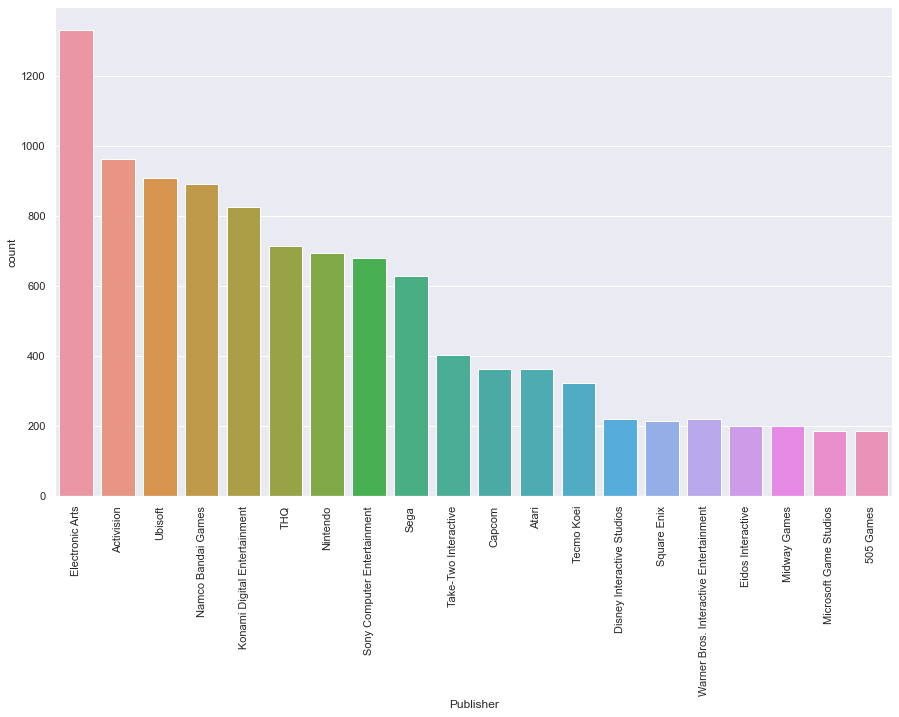

In [112]:
plt.figure(figsize=(15, 9))
sns.countplot(x="Publisher", data=data, order = data.groupby(by=['Publisher'])['Year'].count().sort_values(ascending=False).iloc[:20].index)
plt.xticks(rotation=90);

_Крупнейшие студии, как можно понять, занимают лидирующие места: Electronic Arts и Activision._

# 13. Лучшие мировые продажи в разрезе издателей

In [113]:
sale_pbl = data[['Publisher', 'Global_Sales']]
sale_pbl = sale_pbl.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False).head(20)
sale_pbl = pd.DataFrame(sale_pbl).reset_index()
# sale_pbl

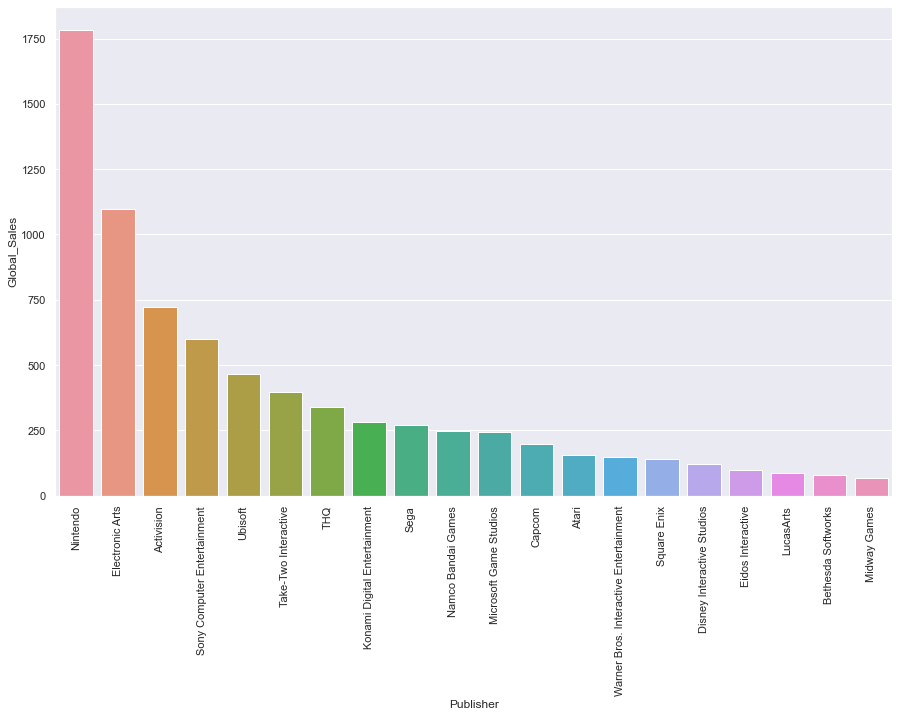

In [115]:
plt.figure(figsize=(15, 9))
sns.barplot(x='Publisher', y='Global_Sales', data=sale_pbl)
plt.xticks(rotation=90);

_А вот здесь логика оказывается обманчива: несмотря на колоссальные отрыв по количеству игр у Electronic Arts и Activision, они проигрывают по продажам своих игр Nintendo! Причём сам Nintendo не входит даже в топ-5 по количеству игр, что говорит о бОльшей популярности их игр (ведь их попросту больше покупали)._

# 14. Сравнение издателей

In [116]:
comp_publisher = data[['Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
comp_publisher.head()

,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Nintendo,41.49,29.02,3.77,8.46,82.74
1,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Nintendo,15.85,12.88,3.79,3.31,35.82
3,Nintendo,15.75,11.01,3.28,2.96,33.00
4,Nintendo,11.27,8.89,10.22,1.00,31.37


In [117]:
comp_publisher = comp_publisher.groupby(by=['Publisher']).sum().reset_index().sort_values(by=['Global_Sales'], ascending=False)
comp_publisher = comp_publisher.head(20)
# comp_publisher

In [118]:
comp_publisher = pd.melt(comp_publisher, id_vars=['Publisher'], 
                         value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], 
                         var_name='Sale_Area', value_name='Sale_Price')
comp_publisher

,Publisher,Sale_Area,Sale_Price
0,Nintendo,NA_Sales,815.71
1,Electronic Arts,NA_Sales,591.43
2,Activision,NA_Sales,428.03
3,Sony Computer Entertainment,NA_Sales,262.79
4,Ubisoft,NA_Sales,249.31
...,...,...,...
75,Disney Interactive Studios,Other_Sales,13.18
76,Eidos Interactive,Other_Sales,8.02
77,LucasArts,Other_Sales,10.50
78,Bethesda Softworks,Other_Sales,9.87


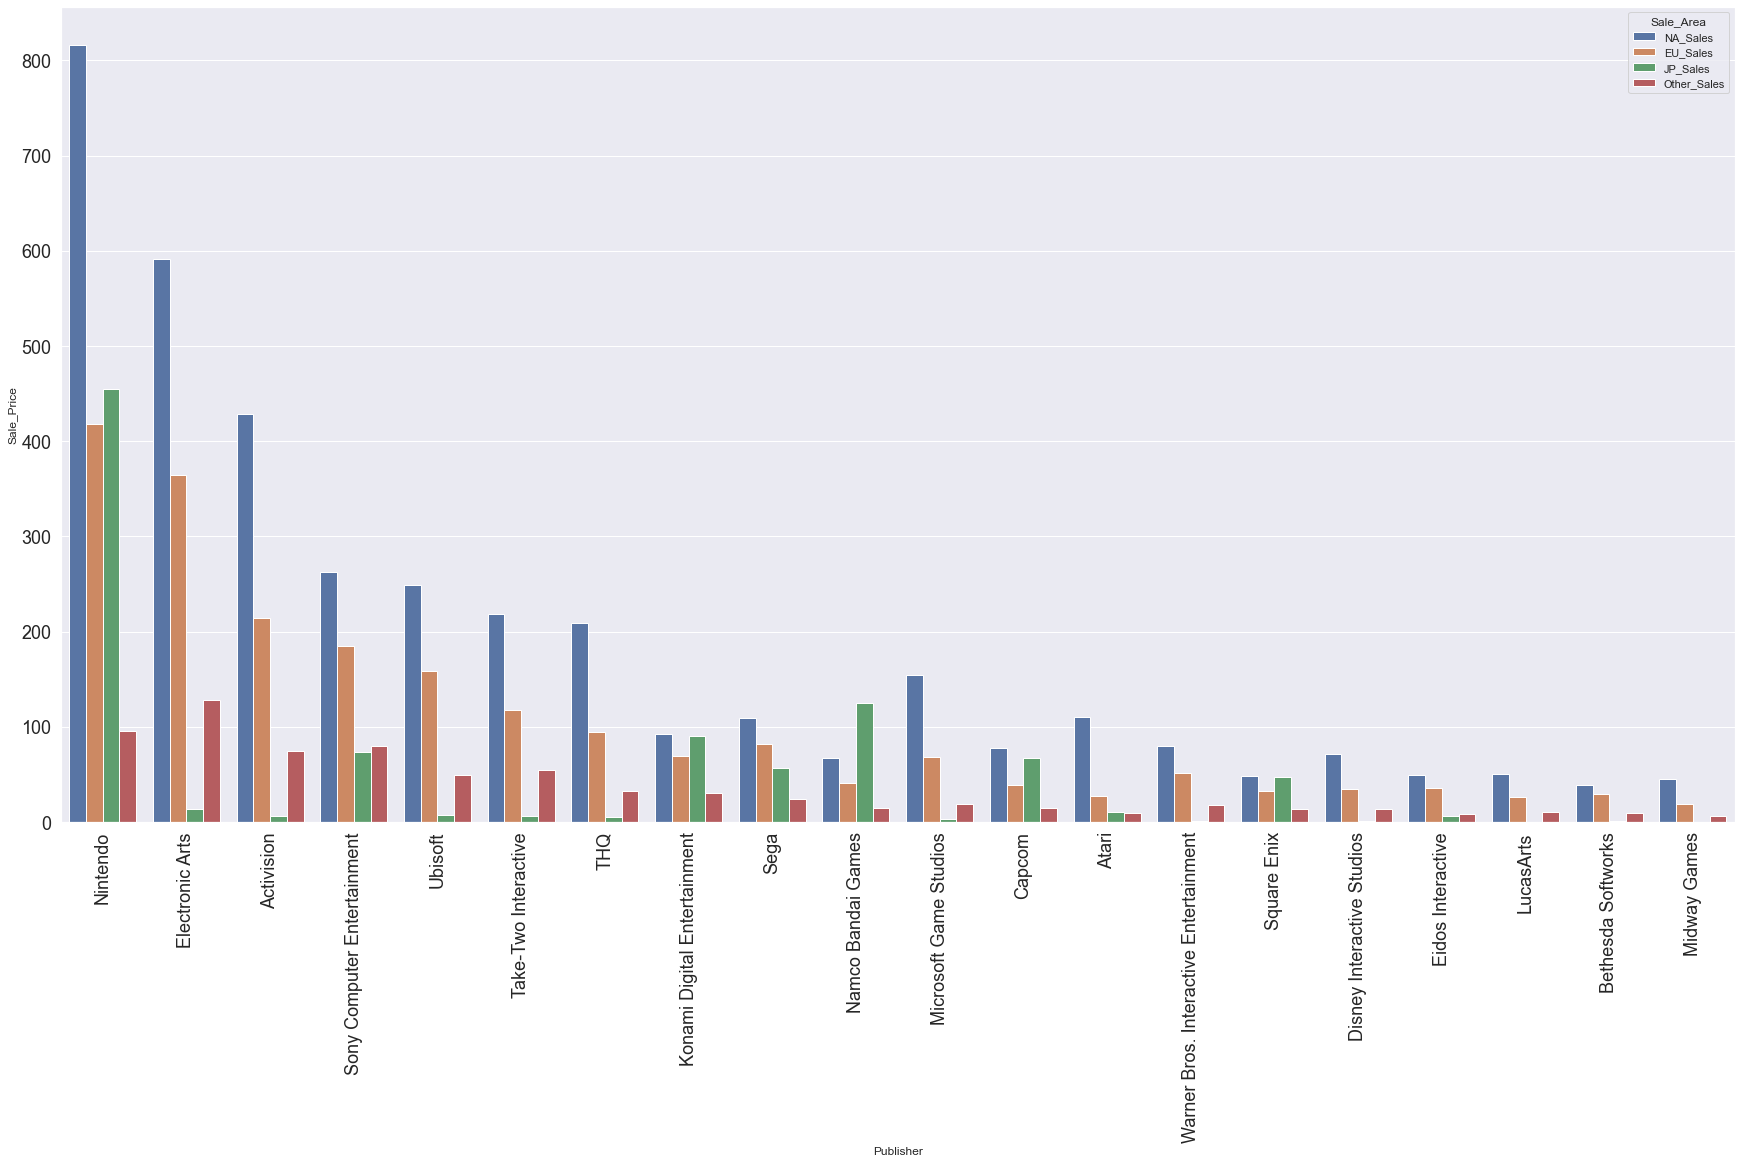

In [121]:
plt.figure(figsize=(30, 15))
sns.barplot(x='Publisher', y='Sale_Price', hue='Sale_Area', data=comp_publisher)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.show()

_Снова видна доминирующая тенденция Америки и Европы, но стоит обратить внимание на Nintendo и Namco Bandai Games, где японцы не только не уступают, но и лидируют (как в последнем случае). При этом заметно, что интерес японцев практически нулевой в отношении Electronic Arts, Activision и Ubisoft, которые активно выпускают игры на ПК (поэтому японцы не покупают их игровую продукцию)._

# 15. Лучший издатель по количеству игр по годам

In [122]:
top_publisher =  data[['Year', 'Publisher']]
top_publisher_df = top_publisher.groupby(by=['Year', 'Publisher']).size().reset_index(name='Count')
top_publisher_idx =  top_publisher_df.groupby(by=['Year'])['Count'].transform(max) == top_publisher_df['Count']
top_publisher_count = top_publisher_df[top_publisher_idx].reset_index(drop=True)
top_publisher_count  = top_publisher_count.drop_duplicates(subset=["Year", "Count"], keep='last').reset_index(drop=True)
# top_publisher_count

In [123]:
publisher= top_publisher_count['Publisher']

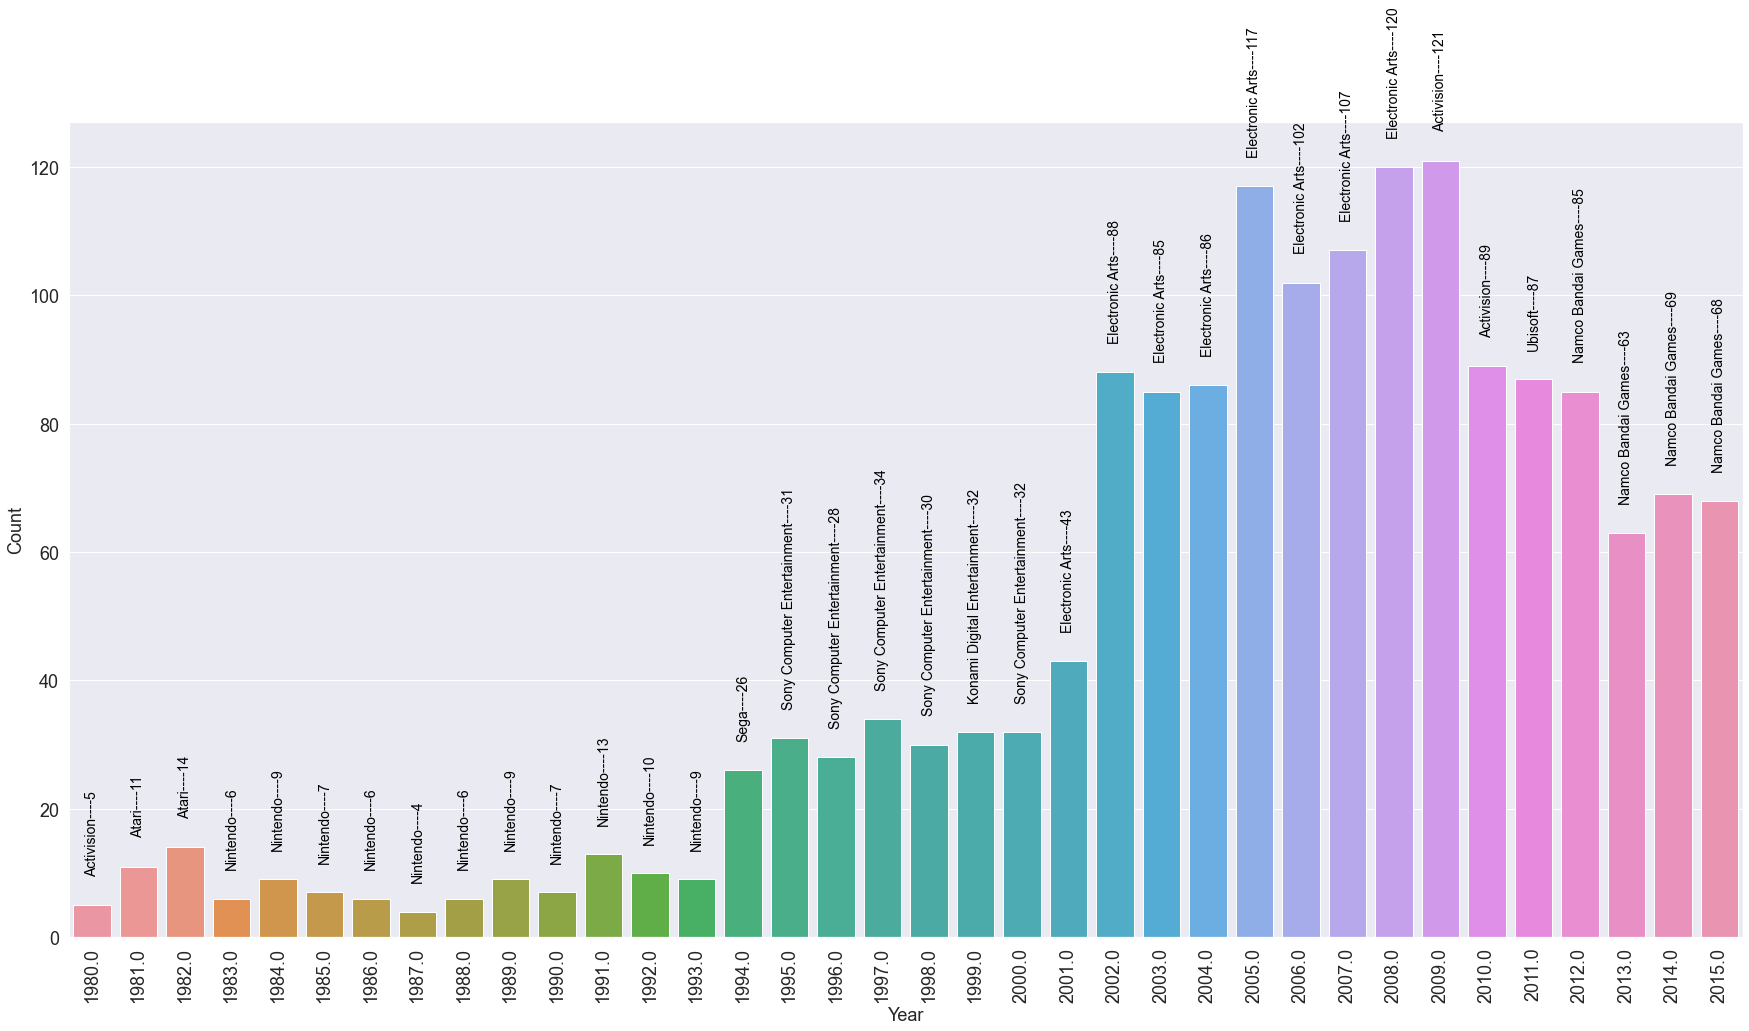

In [132]:
plt.figure(figsize=(30, 15))
g = sns.barplot(x='Year', y='Count', data=top_publisher_count)
index = 0
for value in top_publisher_count['Count'].values:
#     print(asd)
    g.text(index, value + 5, str(publisher[index] + '----' +str(value)), color='#000', size=14, rotation= 90, ha="center")
    index += 1


plt.xlabel('Year', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.show()

_Здесь заметны целые "эпохи" для издателей: сначала господствовал Nintendo, затем единственный год Sega, потом 5 лет Sony, далее господство перешло на 7 лет к Electronic Arts, буквально пару лет пришлось на Activision и Ubisoft, а с 2011 по 2015 год несомненным лидером по количеству игр оказался Namco Bandai Games (примечательно, именно в то время эта студия выпускала многими любимую серию игр Dark Souls)._

# 16. Общий доход по всем регионам

In [133]:
# data.head()

In [134]:
top_sale_reg = data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
# pd.DataFrame(top_sale_reg.sum(), columns=['a', 'b'])
top_sale_reg = top_sale_reg.sum().reset_index()
top_sale_reg = top_sale_reg.rename(columns={"index": "region", 0: "sale"})
top_sale_reg

,region,sale
0,NA_Sales,4370.02
1,EU_Sales,2407.37
2,JP_Sales,1277.27
3,Other_Sales,789.98


<AxesSubplot:xlabel='region', ylabel='sale'>

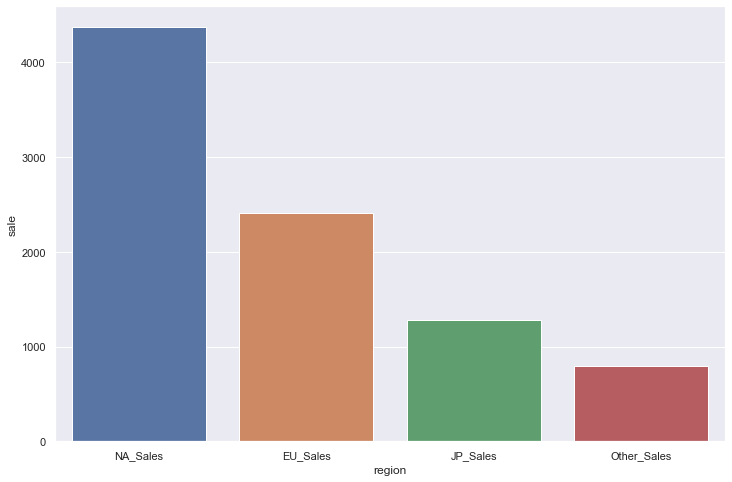

In [135]:
plt.figure(figsize=(12, 8))
sns.barplot(x='region', y='sale', data = top_sale_reg)

In [136]:
labels = top_sale_reg['region']
sizes = top_sale_reg['sale']

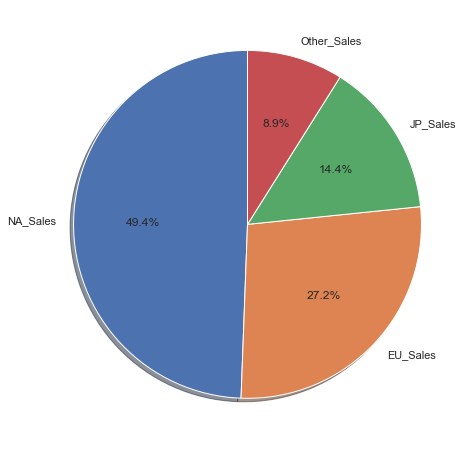

In [138]:
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90);

_Как было подмечено в начале, продажи Америки поражают и занимают почти 50% от всего рынка видеоигр._

# 17. Анализ продаж 

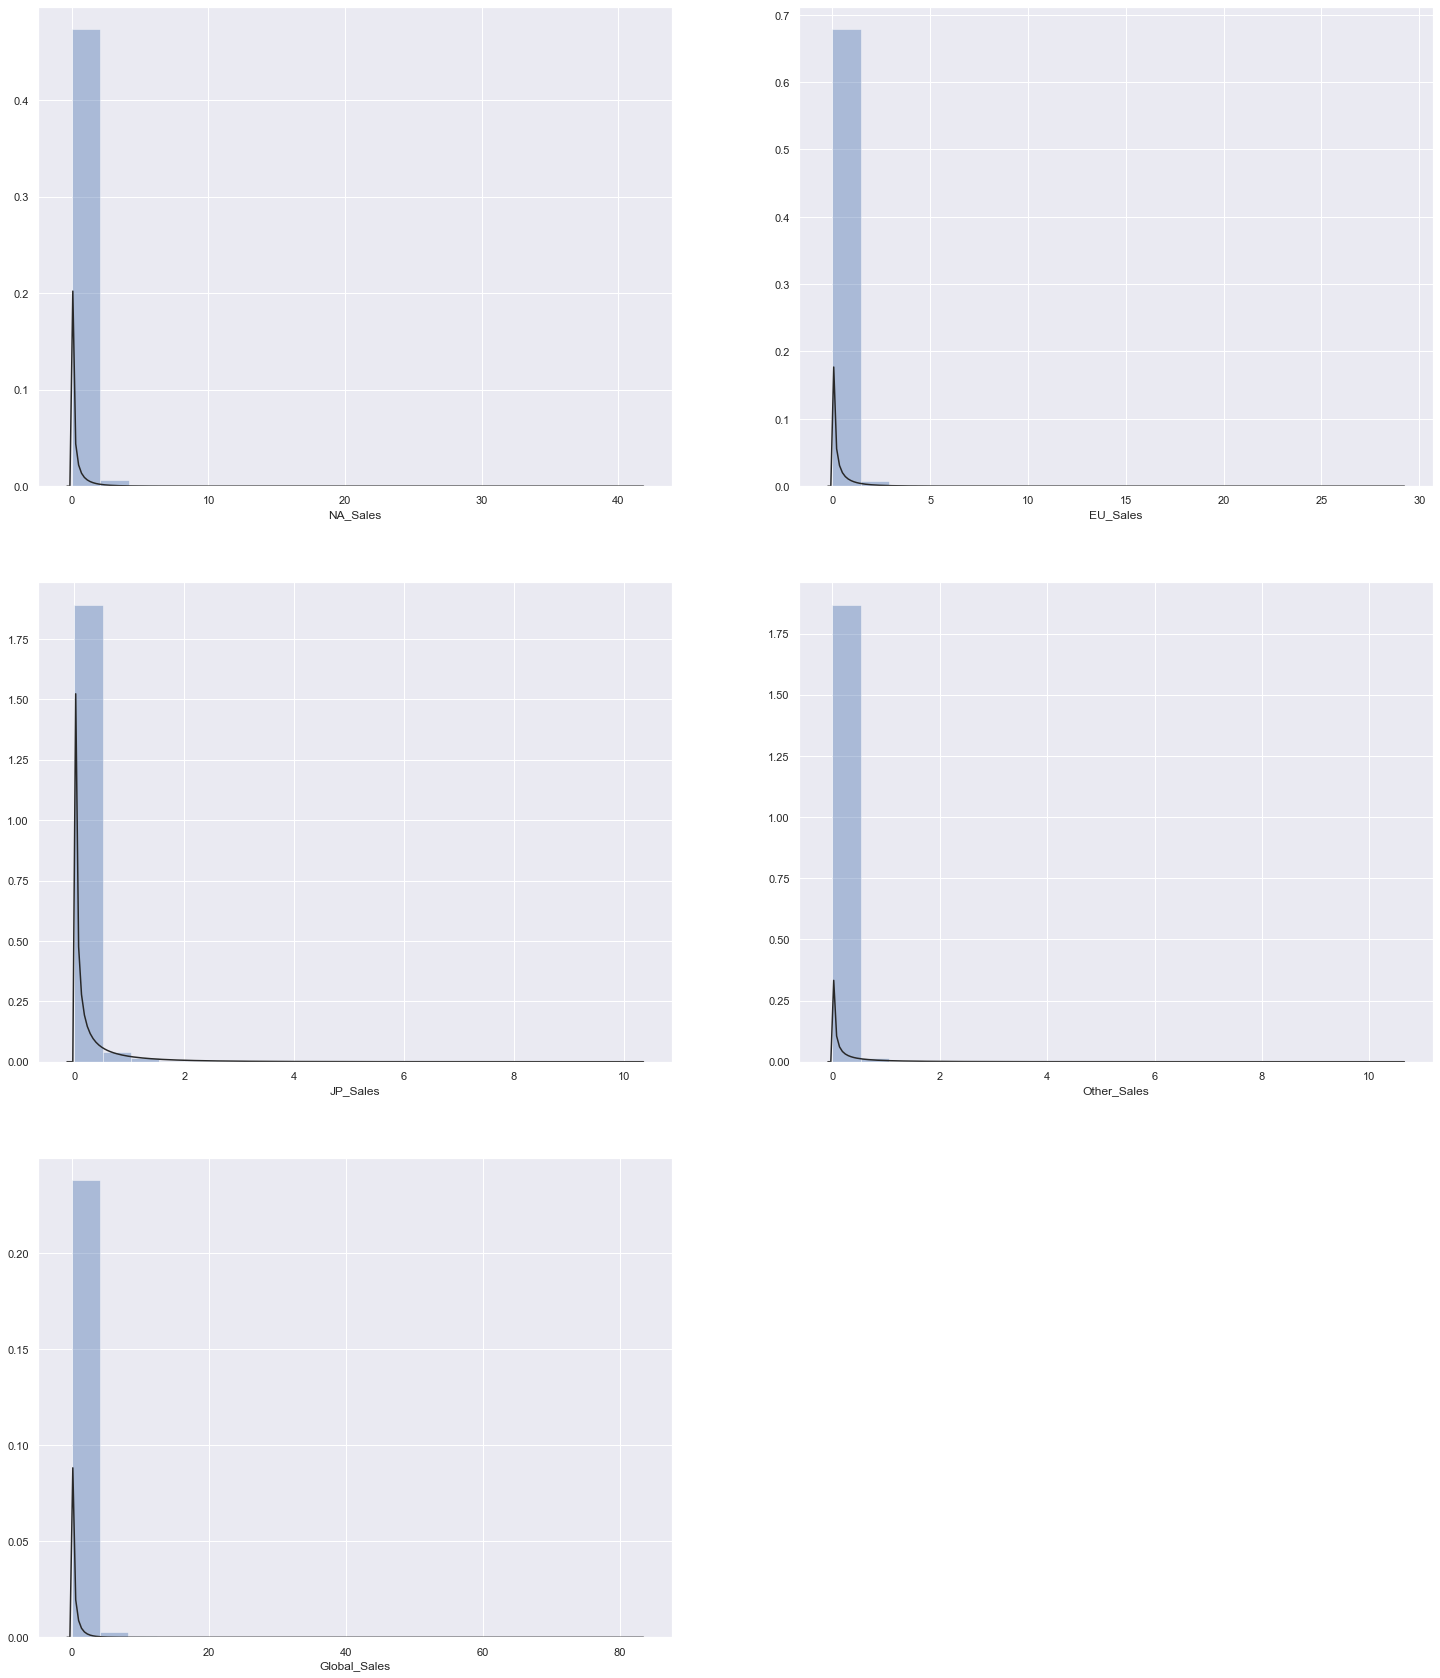

In [154]:
# sns.distplot(data['NA_Sales'],  kde=False, fit=stats.gamma);
# sns.distplot(data['EU_Sales'],  kde=False, fit=stats.gamma);
plt.figure(figsize=(25,30))
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
for i, column in enumerate(sales_columns):
    plt.subplot(3,2,i+1)
    sns.distplot(data[column], bins=20, kde=False, fit=stats.gamma)

_Поскольку большинство игр имеют крайне малые продажи в целом по миру, то для анализа необходимо прологарифмировать имеющиеся данные и затем посмотреть на возможные распределения._

In [252]:
data.shape

(16250, 11)

In [258]:
data_hist_log = data.copy()

In [260]:
data_hist_log = data_hist_log[data_hist_log.NA_Sales != 0]
data_hist_log = data_hist_log[data_hist_log.EU_Sales != 0]
data_hist_log = data_hist_log[data_hist_log.Other_Sales != 0]
data_hist_log = data_hist_log[data_hist_log.JP_Sales != 0]
data_hist_log = data_hist_log[data_hist_log.Global_Sales != 0]

_Посмотрим на pairplot и heatmap:_

In [229]:
data_pair_log = data_pair.copy()
sale_columns = ['NA_Sales', 'EU_Sales', 'Other_Sales']
data_pair_log = data_pair_log[data_pair_log.NA_Sales != 0]
data_pair_log = data_pair_log[data_pair_log.EU_Sales != 0]
data_pair_log = data_pair_log[data_pair_log.Other_Sales != 0]

In [230]:
data_pair_log['NA_Sales'] = np.log(data_pair_log['NA_Sales']);
data_pair_log['EU_Sales'] = np.log(data_pair_log['EU_Sales']);
data_pair_log['Other_Sales'] = np.log(data_pair_log['Other_Sales']);

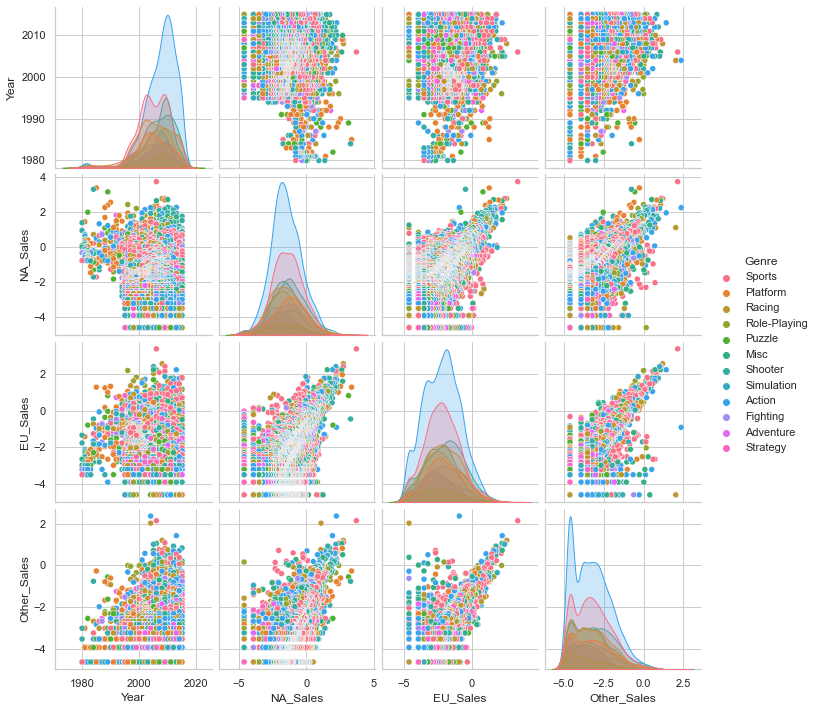

In [231]:
sns.pairplot(data_pair_log, hue='Genre',  palette="husl")

<AxesSubplot:>

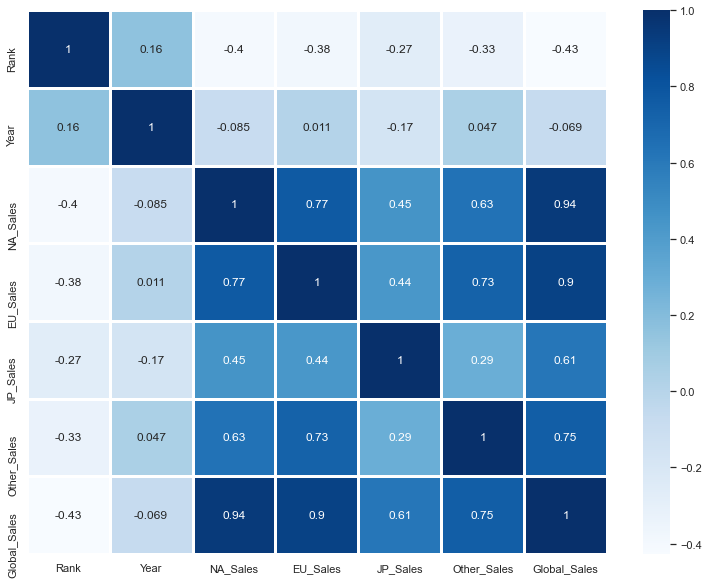

In [143]:
plt.figure(figsize=(13,10))
sns.heatmap(data.corr(), cmap = "Blues", annot=True, linewidth=3)

_По полученным диаграммам можно сделать следующие выводы:_  
_1) Корреляция между годом и количеством продаж несущественна, почти все значения лежат вблизи 0 (что обозначает отсутствие корреляции между признаками)._  
_2) Наиболее взаимосвязанными, как можно логично предположить, являются NA_Sales с Global_Sales и EU_Sales с Global_Sales, поскольку рынки Европы и Америки имеют наибольший вклад в мировые продажи._  
_3) Подтверждается предположение выше о том, что признаки NA_Sales и EU_Sales схожи, имеют высокий коэф-т корреляции._  
_4) Отдельно стоит отметить Японию, которая имеет в целом небольшую корреляцию с остальными регионами, в особенности отличными от Европы и Америки (по-видимому сказывается влияние собственной культуры, распространённой в Японии)._

In [251]:
data_hist_log['NA_Sales']

0        41.49
1        29.08
2        15.85
3        15.75
4        11.27
         ...  
11562     0.03
11838     0.02
11896     0.01
13000     0.03
13281     0.01
Name: NA_Sales, Length: 2336, dtype: float64

_Построим Q-Q plot:_

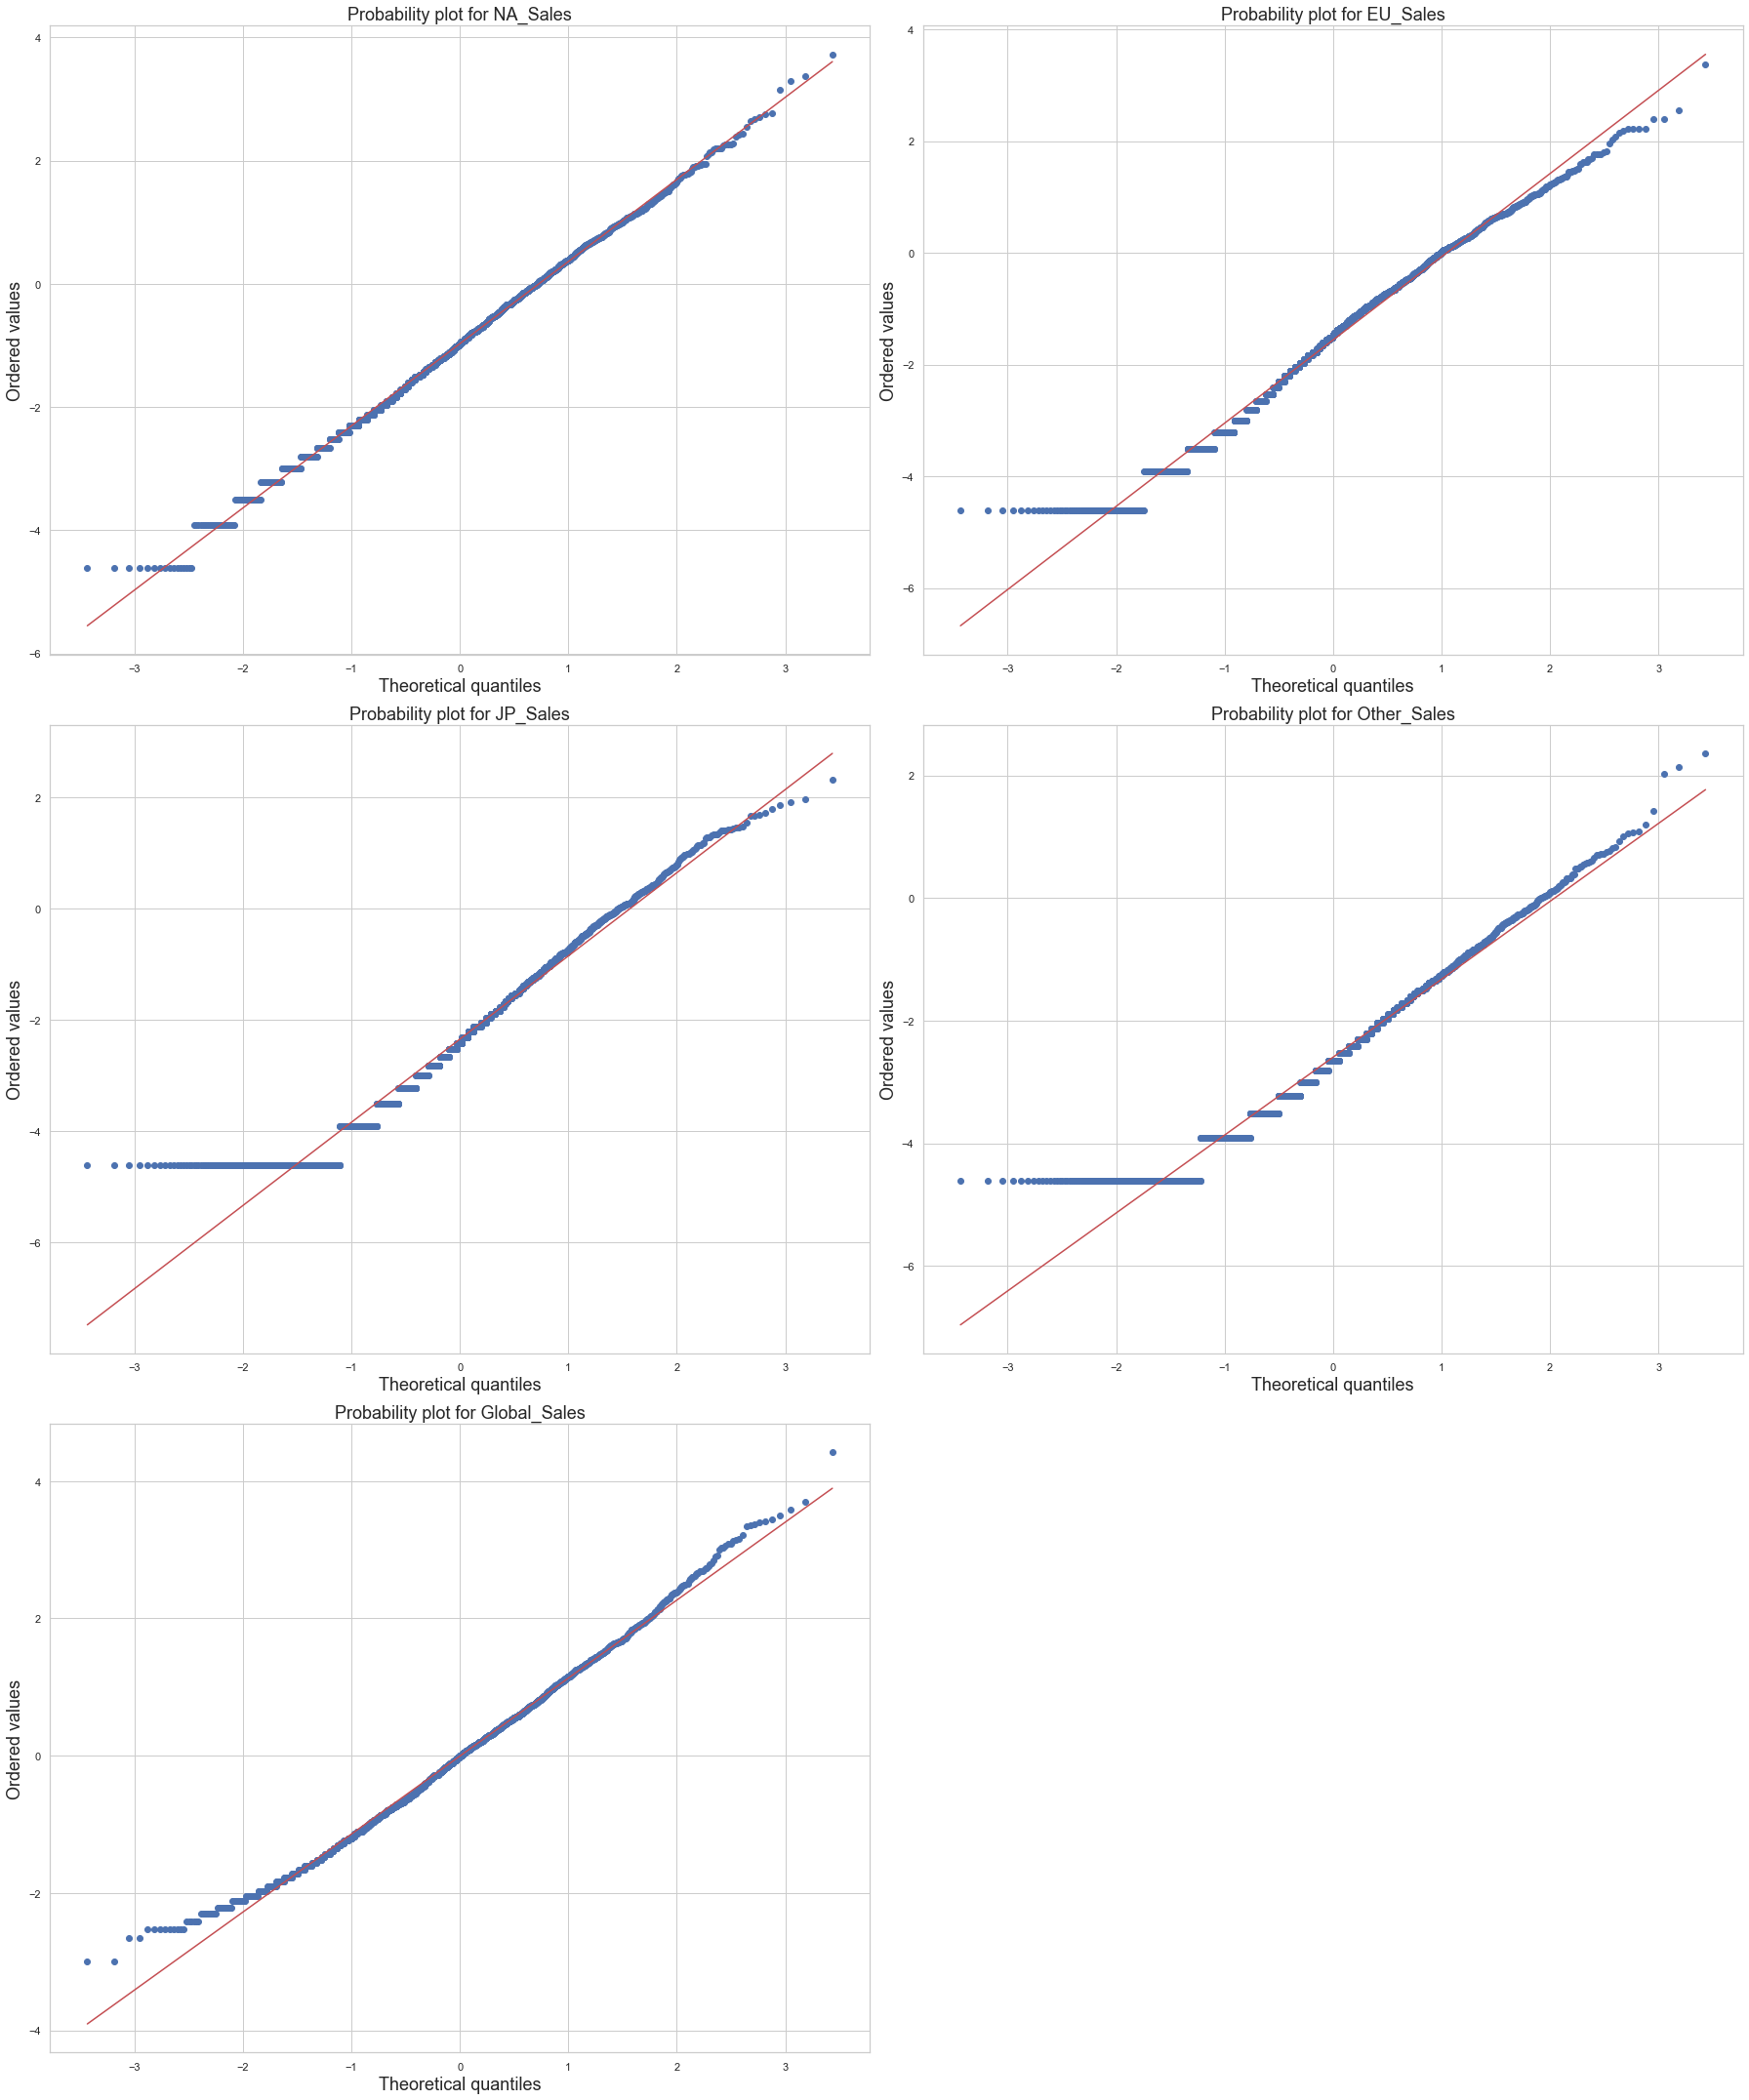

In [263]:
plt.figure(figsize=(25, 30))
for index, column in enumerate(sales_columns, start = 1):
    ax = plt.subplot(3, 2, index)
    sps.probplot(list(np.log(data_hist_log[column])), dist='norm', fit=True, plot=ax)
    ax.set_title(f"Probability plot for {column}", fontsize=18)
    plt.xlabel('Theoretical quantiles', fontsize=18)
    plt.ylabel('Ordered values', fontsize=18)
    plt.tight_layout()

_По Q-Q plot можно сделать предварительный вывод о том, что только NA_sales и Global_sales более всего соответствуют значениям, распределённым нормально._

_Воспользуемся критериями согласия для проверки нормальности:_

In [220]:
alpha = 0.05
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

In [236]:
all_pvalues = np.array([])
dframe = pd.DataFrame() 
for column in sales_columns:
    sample = np.log(data_hist_log[column])
    pvals = np.array([sps.shapiro(sample)[1], 
                      sps.jarque_bera(sample)[1], 
                      sps.kstest(sample, 'norm')[1]])
    rejects = np.array([sps.shapiro(sample)[1] < alpha, 
                        sps.jarque_bera(sample)[1] < alpha, 
                        sps.kstest(sample, 'norm')[1] < alpha])
    dframe[column] = list(zip(pvals,rejects))
    all_pvalues = np.append(all_pvalues, pvals)

dframe = dframe.T
dframe.rename(columns={0: 'Shapiro', 1: 'Jark-Ber', 2: 'Kolmogorov-Smirnov'}, inplace=True)
dframe

,Shapiro,Jark-Ber,Kolmogorov-Smirnov
NA_Sales,"(0.009981651790440083, True)","(0.22881079343248922, False)","(8.154939445893758e-242, True)"
EU_Sales,"(5.011597148558977e-13, True)","(4.07155441584095e-08, True)","(0.0, True)"
JP_Sales,"(1.343858757052844e-22, True)","(1.6653345369377348e-15, True)","(0.0, True)"
Other_Sales,"(6.4488321297115995e-21, True)","(3.7980729672426605e-13, True)","(0.0, True)"
Global_Sales,"(5.554495032811246e-07, True)","(2.8854697844304944e-05, True)","(6.696739370830957e-06, True)"


In [237]:
all_pvalues

array([9.98165179e-003, 2.28810793e-001, 8.15493945e-242, 5.01159715e-013,
       4.07155442e-008, 0.00000000e+000, 1.34385876e-022, 1.66533454e-015,
       0.00000000e+000, 6.44883213e-021, 3.79807297e-013, 0.00000000e+000,
       5.55449503e-007, 2.88546978e-005, 6.69673937e-006])

_Итак, практически все (за исключением одной) проверки отвергают гипотезу о нормальности предложенных данных. Проверим их на совпадение функций распределения по критерию Смирнова (возмём pvals по критерию Шапиро-Уилка):_

In [239]:
all_samples = list()
Df = pd.DataFrame()
for column in sales_columns:
    all_samples.append(np.log(data_hist_log[column]))

for i in range(len(all_samples)):
    t = list()
    for j in range(len(all_samples)):
        t.append((sps.ks_2samp(all_samples[i], all_samples[j])[1],
                 sps.ks_2samp(all_samples[i], all_samples[j])[1] < alpha))
        all_pvalues = np.append(all_pvalues, (sps.ks_2samp(all_samples[i], all_samples[j])[1]))
    Df[sales_columns[i]] = t

Df.index = sales_columns
Df

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
NA_Sales,"(1.0, False)","(4.0602188366191955e-26, True)","(7.596483244566346e-139, True)","(1.581481776041455e-209, True)","(6.164433979939195e-89, True)"
EU_Sales,"(4.0602188366191955e-26, True)","(1.0, False)","(3.939771381453167e-50, True)","(4.4481400893165517e-95, True)","(4.9625027809604224e-183, True)"
JP_Sales,"(7.596483244566346e-139, True)","(3.939771381453167e-50, True)","(1.0, False)","(2.3617314975850552e-09, True)","(0.0, True)"
Other_Sales,"(1.581481776041455e-209, True)","(4.4481400893165517e-95, True)","(2.3617314975850552e-09, True)","(1.0, False)","(0.0, True)"
Global_Sales,"(6.164433979939195e-89, True)","(4.9625027809604224e-183, True)","(0.0, True)","(0.0, True)","(1.0, False)"


In [240]:
all_pvalues

array([9.98165179e-003, 2.28810793e-001, 8.15493945e-242, 5.01159715e-013,
       4.07155442e-008, 0.00000000e+000, 1.34385876e-022, 1.66533454e-015,
       0.00000000e+000, 6.44883213e-021, 3.79807297e-013, 0.00000000e+000,
       5.55449503e-007, 2.88546978e-005, 6.69673937e-006, 1.00000000e+000,
       4.06021884e-026, 7.59648324e-139, 1.58148178e-209, 6.16443398e-089,
       4.06021884e-026, 1.00000000e+000, 3.93977138e-050, 4.44814009e-095,
       4.96250278e-183, 7.59648324e-139, 3.93977138e-050, 1.00000000e+000,
       2.36173150e-009, 0.00000000e+000, 1.58148178e-209, 4.44814009e-095,
       2.36173150e-009, 1.00000000e+000, 0.00000000e+000, 6.16443398e-089,
       4.96250278e-183, 0.00000000e+000, 0.00000000e+000, 1.00000000e+000])

_По критерию Смирнова отвергаются все гипотезы о совпадении функций распределения для всех признаков._

_Было совершено 40 проверок статистических гипотез, поэтому вероятность совершить хотя бы 1 ошибку первого рода в этом случае намного больше, чем желаемый уровень в $\alpha=0.05$. Поэтому применим множественную проверку гипотез по методу Холма (наиболее мощный общий метод):_

In [247]:
multipletests(all_pvalues, method = 'holm')[0][:15].reshape(5, 3)

array([[False, False,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [248]:
multipletests(all_pvalues, method = 'holm')[0][15:40].reshape(5, 5)

array([[False,  True,  True,  True,  True],
       [ True, False,  True,  True,  True],
       [ True,  True, False,  True,  True],
       [ True,  True,  True, False,  True],
       [ True,  True,  True,  True, False]])

_Видно, что только первые 2 гипотезы из 15 не отвергаются в случае проверок критериями согласия, а в остальных 25 проверках результат не поменялся (где отвергались гипотезы, там и отвергаются)._

_После множественной проверки гипотез всё равно есть критерий, по которому нормальность данных отвергается -> отвергаем гипотезу._

_Итак, мы рассмотрели исходный датасет, используя разнообразную визуализацию, проверку гипотез, дисперсионный и корреляционный анализы._
# Общие выводы по всей работе:
1) Были выявлены годы самой высокой производительности студий разработки игр (2007-2011гг), определены самые популярные и перспективные жанры и отдельные игры.  

2) Показано, что количество игр не всегда влияет на общее количество продаж, например, студия Nintendo, имея практически в 2 раза меньше игр, опередила по количеству вырученных денег Electronic Arts.  

3) Рассмотрено влияние регионов на продажи и используемые устройства для игр, а также предпочтение одной игры другой в зависимости от местоположения, например, Япония не использует персональные компьютеры для игр, обращая внимание на консоли и играя при этом в большинстве своём в ролевые игры от азиатских студий. С другой стороны, Европа и Америка используют примерно одни и те же устройства и играют в одни и те же игры (что наглядно подтверждается визуализациями и данными корреляций).   

4) Проведён анализ продаж игр, по которым есть данные по всем регионам. Выявлена гегемония небольшого количества лучших игр, для проведения анализа был совершён переход к логарифмическим данным. Ни одна из выборок для продаж по регионам не подчиняется нормальному распределению, к тому же выборки имеют между собой различные распределения. Необходимо отметить использование множественной проверки гипотез во избежание преувеличения возможной ошибки.  